# Feature_Importance

목차:

**[I. 데이터 불러오기 및 확인](#one)**
- [a. Random Forest](#one-a)

**[II. Feature Importance](#two)**
- [a. feature importance](#two-a)
- [b. Permutation Feature Importance](#two-b)
- [c. SHAP](#two-c)
    
**[III. Feature Selection](#three)**
- [a. rfe](#three-a)
- [b. ShapRFECV](#three-b)
- [c. BourtaPy](#three-c)
- [d. BorutaShap](#three-d)    

**[IV. Modeling](#four)**

In [4]:
# -*- coding:utf-8 -*-

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance , plot_tree
from catboost import CatBoostClassifier
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score

from sklearn.model_selection import train_test_split

# multi-label classification
class trees_classifier:
    def __init__(self, train_x,train_y,name_model):
        self.train_x = train_x
        #self.X_test = X_test
        self.train_y = train_y
        
        self.name_model = name_model

        #self.pred_rf = None
        #self.pred_xgb = None
        #self.pred_cat = None
        
        
    #def RandomForestClf(self):
        #rf_clf = RandomForestClassifier(random_state=0, max_depth = 5)
        #rf_clf.fit(self.X_train, self.y_train)
        #pred_rf = rf_clf.predict(self.X_test)
        #self.pred_rf = pred_rf
        #return pred_rf, rf_clf
    
    
    def xgbClf(self):
        xgb_clf = XGBClassifier(random_state = 0, eval_metric= 'merror', objective = 'multi:softmax')
        xgb_clf.fit(self.X_train, self.y_train, verbose=False)
        pred_xgb = xgb_clf.predict(self.X_test)
        self.pred_xgb = pred_xgb
        return pred_xgb, xgb_clf
    
    
    def catboostClf(self):
        cat_clf = CatBoostClassifier(random_seed = 0, loss_function='MultiClass')
        cat_clf.fit(self.X_train, self.y_train)
        pred_cat = cat_clf.predict(self.X_test)
        self.pred_cat = pred_cat
        return pred_cat, cat_clf
       
    def model_fit(self):
        skf = StratifiedKFold(n_splits=2)
        for train_index, test_index  in skf.split(self.train_x,self.train_y):
            X_train, X_test = self.train_x.iloc[train_index], self.train_x.iloc[test_index]
            y_train, y_test = self.train_y.iloc[train_index], self.train_y.iloc[test_index]
            
        scorers = {
            'f1_score':make_scorer(f1_score,average='macro'),
            'f1_score_weighted':make_scorer(f1_score,average='weighted'),
            'precision_score': make_scorer(precision_score,average='macro'),
            'recall_score': make_scorer(recall_score,average='weighted'),
            'accuracy_score': make_scorer(accuracy_score)
          }

        if self.name_model == 'LGBMClassifier':
            model = lgb.LGBMClassifier(n_estimators=1000)
            model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)    
        else:
            param_grid={}
            if self.name_model == 'Decision Tree Classifier':
                model_clf = DecisionTreeClassifier()
                param_grid = {'min_samples_leaf': [i for i in range(2,10)]}
            elif self.name_model == 'Random Forest':
                model_clf = RandomForestClassifier()
                param_grid = {'n_estimators': [100,300, 400, 500, 600,800], 'min_samples_split': [2,5,10,30,60], 'min_samples_leaf': [20, 25, 30, 35, 40], 
                              'max_features': ['auto'], 'max_depth': [5, 6, 7, 8, 9, 10], 'criterion': ['gini'], 'bootstrap': [False]}
            elif self.name_model == 'XGBClassifier':
                model_clf = xgb.XGBClassifier(objective='reg:squarederror') #classfication으로 바꾸기
                param_grid = {'n_estimators': [200, 300, 400], 
                              'learning_rate': [0.001, 0.003, 0.005, 0.006, 0.01],
                              'max_depth': [4, 5, 6]}            
            model = GridSearchCV(model_clf, param_grid=param_grid, cv=skf, scoring = scorers, refit = "f1_score_weighted",verbose=False)
            model.fit(X_train, y_train)
            print(f'{self.name_model} score :',model.best_score_)
        return model

In [6]:
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

## I. 데이터 불러오기 및 확인

In [7]:
df = import_db('mart')
df.to_csv('mart_test.csv',encoding='cp949')

In [9]:
df.drop(['store_cd','store_nm','sale_avg','address','x','y','x_y_list','sale_grade_ahi','sale_grade_hist'], axis=1, inplace=True)

In [10]:
X = df.copy()
y = X.sale_grade
X.drop('sale_grade',axis=1, inplace=True)

dat1 = df.copy()
target = dat1.sale_grade
dat1.drop('sale_grade',axis=1, inplace=True)

## Random Forest

- 배깅 알고리즘의 하나로(동일한 알고리즘으로 여러 분류기를 만들어 보팅으로 최종 결정하는 알고리즘 )
    * (1) 동일한 알고리즘을 사용하는 일정 수의 분류기 생성
    * (2) 각각의 분류기는 부트스트래핑(Bootstrapping)방식(전체 데이터에서 일부 데이터를 중첩을 허용)ㄴ으로 생성된 샘플데이터를 학습
    * (3) 최종적으로 모든 분류기가 보팅을 통헤 예측 결정

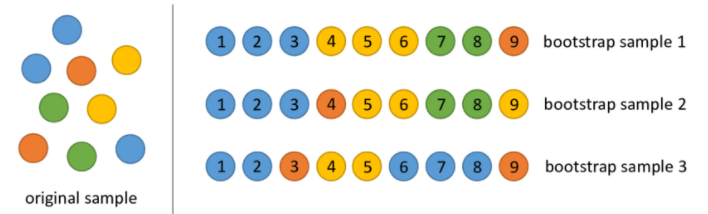

- 장점 
    * 결정 트리의 쉽고 직관적인 장점 보유   
    * 앙상블 알고리즘 중 빠른 수행 속도
    * 다양한 분야에서 좋은 성능
    * 성능이 뛰어나고 매개변수 튜닝을 많이 하지 않아도 잘 작동하며 데이터의 스케일을 맞출 필요 없음
- 단점
    * 하이퍼 파라미터가 많아 튜닝을 위한 시간이 많이 소요됨
    
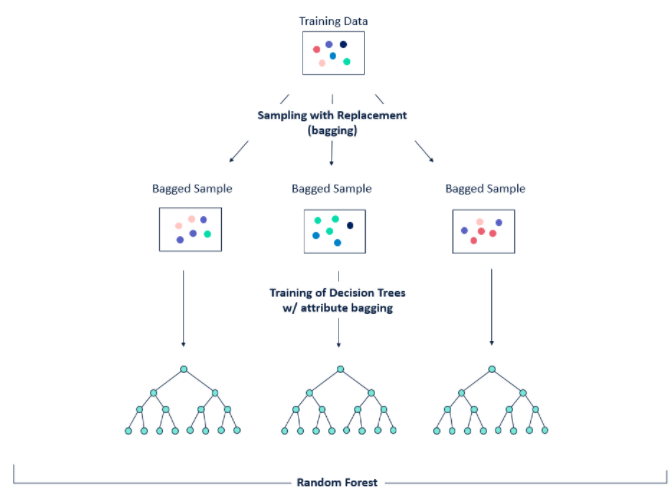

- 중요 매개변수 : n_estimators, max_features 이고 max_depth(사전 가지치기 옵션)
- RF는 특히 많은 입력변수가 존재하는 경우에 잘 작동하는것으로 알려져있어(Dudoit등, 2002) 고차원 자료 (high-dimensional data)의 분석에도 사용이 용이

변수 | 설명
------- | -------
**n_estimators** | 결정트리의 갯수, 무작정 늘리면 성능 좋아지는것 대비 시간 오래걸림
**min_samples_split** | 노드를 분할하기 위한 최소한의 샘플 데이터수 → 과적합을 제어하는데 사용
|작게 설정할 수록 분할 노드가 많아져 과적합 가능성 증가
**min_samples_leaf** | 리프노드가 되기 위해 필요한 최소한의 샘플 데이터수, 
|min_samples_split과 함께 과적합 제어 용도
**max_features** | 최적의 분할을 위해 고려할 최대 개수,Default = 'auto'
|int : 피처 갯수, float:비중, 
|sqrt or auto : 전체피처중 피처개수만큼 선정,
|log 전체 피처중 log2(전체 피처 개수) 만큼 선정
**max_depth** | 트리의 최대 깊이, 완벽하게 클래스 값이 
|결정될 때 까지 분할(데이터 개수가 min_samples_split보다 작아질 때까지 분할), 
|깊이가 길면 과적합 우려 
**max_leaf_nodes** | 리프노드의 최대 개수


In [28]:
model = trees_classifier(X, y,'Random Forest')

In [29]:
model.model_fit()

C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Random Forest score : 0.6052631578947368


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [False], 'criterion': ['gini'],
                         'max_depth': [5, 6, 7, 8, 9, 10],
                         'max_features': ['auto'],
                         'min_samples_leaf': [20, 25, 30, 35, 40],
                         'min_samples_split': [2, 5, 10, 30, 60],
                         'n_estimators': [100, 300, 400, 500, 600, 800]},
             verbose=False)

In [31]:
RF = model.model_fit()

C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Random Forest score : 0.6052631578947368


In [37]:
cv_results_df = pd.DataFrame(RF.cv_results_)
print(cv_results_df)

column = cv_results_df.loc[:, ["params"]]
print(column)

best_row = cv_results_df[cv_results_df['rank_test_score'] == 1]
print(best_row)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.061895      0.000984         0.006987        0.000981   
1         0.183614      0.005016         0.023283        0.002713   
2         0.229680      0.005690         0.031648        0.000864   
3         0.286299      0.002712         0.027415        0.000589   
4         0.342726      0.014702         0.042312        0.000804   
..             ...           ...              ...             ...   
895       0.215431      0.002119         0.026756        0.003568   
896       0.273334      0.012151         0.032851        0.005583   
897       0.358712      0.027199         0.031432        0.003266   
898       0.413283      0.016823         0.048795        0.002207   
899       0.549384      0.014989         0.057866        0.010342   

    param_bootstrap param_criterion param_max_depth param_max_features  \
0             False            gini               5               auto   
1             False    

In [42]:
best_row

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.061895,0.000984,0.006987,0.000981,False,gini,5,auto,20,2,100,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.631579,0.578947,0.605263,0.026316,1


In [41]:
best_score = RF.best_score_
print(best_score)

cv_results_df = pd.DataFrame(RF.cv_results_)
best_row = cv_results_df.loc[[RF.best_index_]]
print(best_row)

best_max_depth = RF.best_params_['max_depth']
print(best_max_depth)

0.6052631578947368
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.061895      0.000984         0.006987        0.000981   

  param_bootstrap param_criterion param_max_depth param_max_features  \
0           False            gini               5               auto   

  param_min_samples_leaf param_min_samples_split param_n_estimators  \
0                     20                       2                100   

                                              params  split0_test_score  \
0  {'bootstrap': False, 'criterion': 'gini', 'max...           0.631579   

   split1_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.578947         0.605263        0.026316                1  
5


In [48]:
cv_results_df.T

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
mean_fit_time,0.061895,0.183614,0.22968,0.286299,0.342726,0.530852,0.062582,0.24677,0.268124,0.463341,...,0.292969,0.348061,0.407156,0.563384,0.074696,0.215431,0.273334,0.358712,0.413283,0.549384
std_fit_time,0.000984,0.005016,0.00569,0.002712,0.014702,0.03493,0.000535,0.002889,0.040094,0.05746,...,0.006002,0.027034,0.012553,0.015101,0.006403,0.002119,0.012151,0.027199,0.016823,0.014989
mean_score_time,0.006987,0.023283,0.031648,0.027415,0.042312,0.059649,0.010485,0.022555,0.020847,0.060291,...,0.027844,0.030736,0.044884,0.062624,0.008072,0.026756,0.032851,0.031432,0.048795,0.057866
std_score_time,0.000981,0.002713,0.000864,0.000589,0.000804,0.00466,0.001484,0.003451,0.000144,0.005213,...,0.000956,0.00302,0.005604,0.002374,0.000234,0.003568,0.005583,0.003266,0.002207,0.010342
param_bootstrap,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
param_criterion,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,...,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini
param_max_depth,5,5,5,5,5,5,5,5,5,5,...,10,10,10,10,10,10,10,10,10,10
param_max_features,auto,auto,auto,auto,auto,auto,auto,auto,auto,auto,...,auto,auto,auto,auto,auto,auto,auto,auto,auto,auto
param_min_samples_leaf,20,20,20,20,20,20,20,20,20,20,...,40,40,40,40,40,40,40,40,40,40
param_min_samples_split,2,2,2,2,2,2,5,5,5,5,...,30,30,30,30,60,60,60,60,60,60


## II. Feature Importance

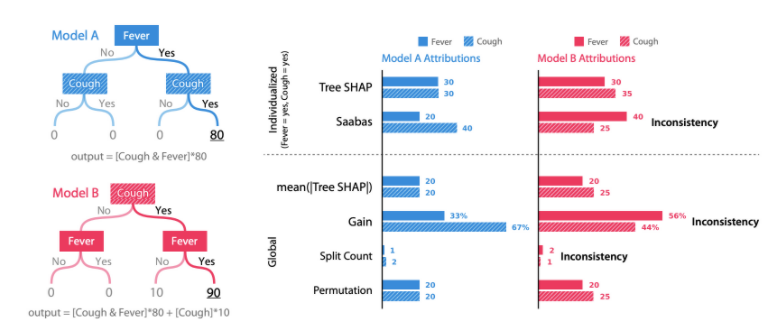

> Tree Model A와 B의 Feature는 Fever, Cough로 동일하지만 Split 순서가 다름, 순서에 따라 Gain, Split Count등의 산출값이 달라져 -> SHAP는 Split 순서와 무관하게, Consistent 한 Feature Importance를 계산 가능

- Random Permutation 에 대해 중요도를 측정하기 때문에, 일관성이 없습니다.
- 설명변수 간 다중공선성이 존재하는 경우 결과과 왜곡되고 Feature 간의 의존성을 간과
- 음의 영향력(-)을 계산하지 않음
- 모델이 negative feature에 대한 학습을 의도적으로 무시하기 때문에 에러가 높아지는 변수는 결과에 포함하지 않음

In [11]:
predictionxgb        model = RandomForestClassifier()
        skf = StratifiedKFold(n_splits=2)
        for train_index, test_index  in skf.split(X,y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        val_pred = model.predict(X_test)
        score = f1_score(y_test, val_pred, average='weighted')

In [118]:
import seaborn as sns
def plot_feature_importance(model, X_train, figsize=(12, 6)):
    sns.set_style('darkgrid')
    
    # Plot feature importance
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=figsize)
    plt.rc("font",family="Malgun Gothic")
    plt.rc("axes",unicode_minus=False)
    
    plt.barh(pos, feature_importance[sorted_idx], align='center',color = 'teal' )
    plt.yticks(pos, X_train.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

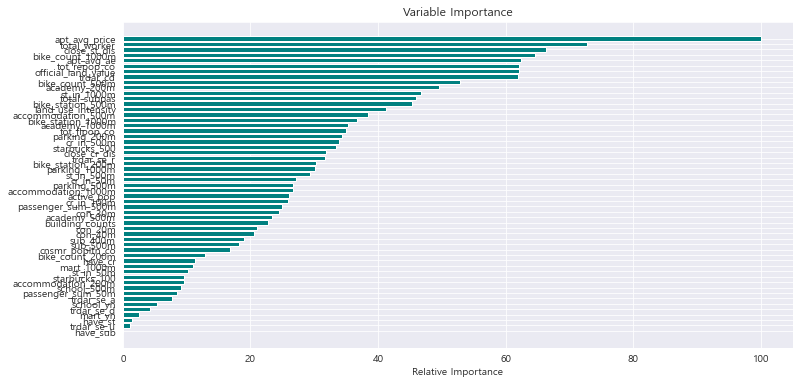

In [119]:
plot_feature_importance(model,X)

### Permutation Feature Importance 

- permutation : 확인하고자 하는 특성치(j열)을 순서만을 shuffle한 새 데이터 행렬 X^perm을 만들어 Base 성능과 차이를 Feature Importance(FI^j)로 사용 
- 장점 
    * FI^j = e^perm / e^base로 오류 비율로 정의할 경우 FI값이 정규화 되어 서로 다른 문제끼리 비교 가능
    * Baseline 모델로 많이 쓰이는 Tree 계열모델에 손쉽게 사용가능
- 단점
    * 통상 레이블에 있는 supervised-learning 에서만 사용가능 (Loss 구할때 필요)
    * permute 시 비현실적인 데이터가 발생할 수 있음
    * Permute는 무작위로 섞는 것이기 때문에, 아주 많이 시험하지 않는 이상 FI 간 순서가 바뀔 여지가 다분 -> SHAP 에서 해결 

Text(0.5, 0, 'Permutation Importance')

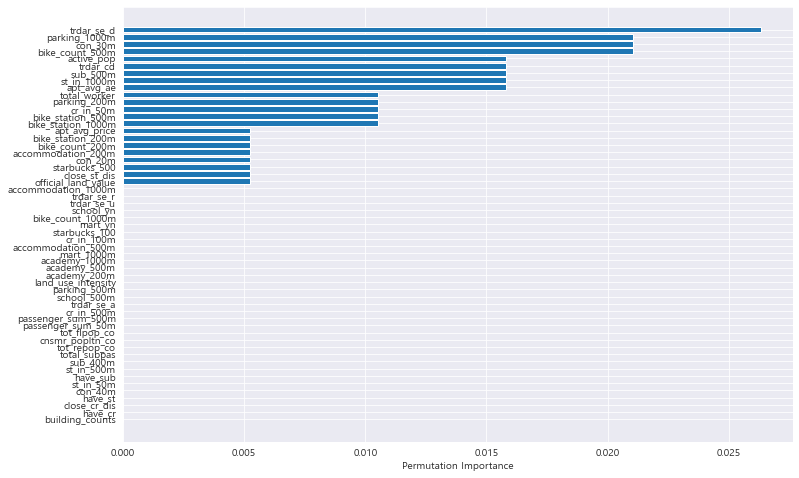

In [124]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(12,8))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [84]:
perm = PermutationImportance(model, random_state=0).fit(X_test, y_test)
perm_feat_imp = pd.Series(perm.feature_importances_, index=feats).sort_values(ascending=False)
eli5.show_weights(perm)

Weight,Feature
0.0263 ± 0.0000,x0
0.0263 ± 0.0000,x47
0.0263 ± 0.0000,x2
0.0211 ± 0.0211,x34
0.0211 ± 0.0211,x10
0.0211 ± 0.0211,x28
0.0211 ± 0.0211,x12
0.0158 ± 0.0258,x9
0.0158 ± 0.0258,x17
0.0158 ± 0.0258,x30


## shap

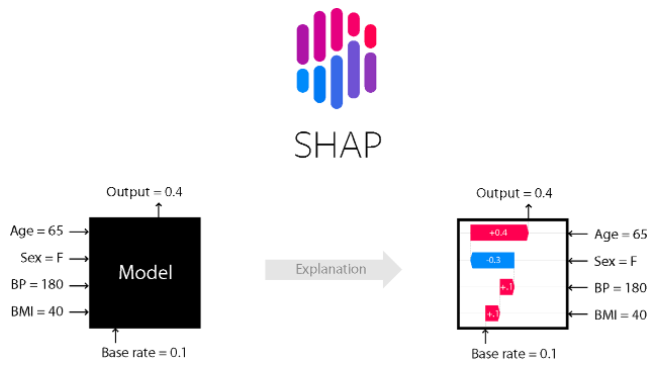

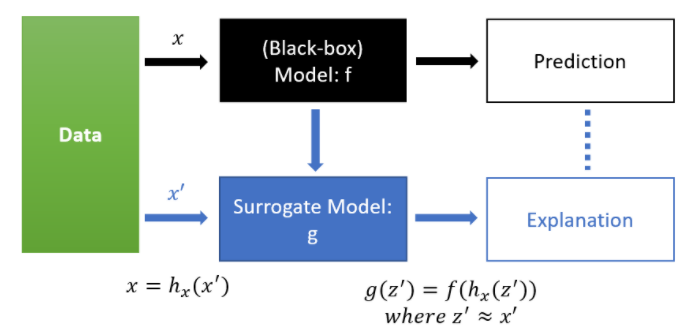

- LIME(Local Interpretable Model-agnostic Explanations) 
    * Local:단일 관측치(혹은 데이터셋 일부분)에 대한 모델 예측값 해석에 대한 초점을 둠 
    * Global : 모델의 각 부분(or 학습된 전체 모델)이 예측값을 어떻게 만드는지에 대해 초점을 둠 
    * 장점:
        * Global한 해석이 아닌 개별 데이터 인스턴스에 대한 local 해석력 제공
        * Perturbation 의 방식을 다르게 하면 model-agnostic하게 해석할 수 있는 도구를 제공
        * 추후에 나오는 SHAP보다 계산량이 적음
    * 단점:
        * 데이터 분포가 국소(local)적으로도 매우 비선형적이면 local에서 선형성을 가정하는 LIME은 설명력에 한계
        * 하이퍼 파라미터에 따라서 샘플링 성능이 들쑥날쑥하는 불안정성
        * Data의 종류(이미지,텍스트,,,)에 따라서, 그리고 어떤 surrogate 모델을 고르느냐에 따라서 데이터 perturbation 방식이 다르게 해야하므로, model-agnostic 방법이 갖는 장점인 유연성을 다소 퇴색시킴
- Surrogate Model : 원래 모델 자체로 해석하기 어려울 때 외부에 구조가 단단한 대리(Surrogate) 모델 두어 해석
- model-agnostic : 학습에 사용되는 model이 무엇인지에 구애받지 않고 독립적으로 모델을 해석할 수 있다는 의미(학습에 사용되는 모델과 설명에 사용되는 모델을 분리)
    * Model-Agnostic Methods'는 원래 모델을 블랙박스로 보고, 모델 내부 변수에 접근하지 않은채 모델의 Input과 Output을 조절하면서 그 변동에 기반하여 해석하는 방법론 -> 복잡한 전역데이터 대신 국소적으로 비교적 해석이 가능한 모델로 근사시키거나(해석이 간단한 surrogate모델 활용) 확인하고자 하는 특성치 순열을 Shuffle하여 특성을 무효화함으로써 주요도를 파악하는 기법을 활용
        * Partial Dependence Plot
        * Individual Conditional Expectation
        * Permutation Feature Importance
        * Local Surrogate(LIME)
        * SHAP(Shapley Additive explanations) : 내부변수 랜덤성에 의해 발생하는 예측결과 불공정성(LIME의 단점)을 개선하고, addivity/Consistency/Missingness 요건을 충족시키는 SHAP

- 게임이론을 바탕으로, Game에서 각 Player의 기여분을 계산하는 방법(죄수의 딜레마)
- SHAP (Shapley Additive Explanations) by Lundberg and Lee (2016) 
- SHAP은  LIME과  Shapley  value를  연결한  이론
    * LIME은  Data에  변형을  주며  블랙박스  모델의  예측에  어떤  영향이  있는지를  테스트하여  가중치를  계산하는  이론이다(Molnar,  Christoph,2019)
    * Shapley  value는  coalitional  game  theory를  기반의  이론으로  feature의  기여도를  나타내는 지표이다(Shapely : 각 예측 변수 (특성)가 기계 학습 모델에서 갖는 기여도의 척도)
    * LIME은 관측치가 원본 데이터에 얼마나 가까운지에 따라 가중치를 매김, 연합 벡터에 0이 많을수록, LIME의 가중치는 작아집
    * SHAP은 Shapley value 측정에서 연합 벡터가 얻은 가중치에 따라 샘플링된 관측치에 가중치를 부여합니다. 작은 연합(1이 거의 없는) 또는 큰 연합(1이 많은)이 큰 가중치를 얻게 됨
    * 장점 
        * Model-Agnostic 방법론 중에서 Explanation model이 가져야할 좋은 특성들이 이론적으로 잘 증명됨.
        * 각 관측치에 대한 Local Explanation뿐만 아니라, 각 feature 별 SHAP mean으로 Global Explanation도 얻을 수 있음
    * 단점
        * KernalSHAP의 경우 속도가 느리다.
        * 자칫하면 SHAP value를 원인/결과로 해석할 여지가 있음
    

- XAI 분석을 위한 오픈 소스 파이썬 패키지 SHAP 해석 및 모델 개선 

- 계산 효율성을 향상시키기 위해 SHAP 값을 근사화하는 세 가지 방법이 있습니다. 
    
    * KernelSHAP : Linear LIME + Shapley Value / Truly Model-Agnostic / Relatively Slow / Approximate calculation
    
    * TreeSHAP : Tree based Model / Fast / Exact calculation
    
    * Deep SHAP, GradientSHAP : DeepLearning based Model
        * 모든 Class 마다 SHAP 값을 갖는다는 것을 감안하자,
        * 각 Class를 예측해내는데 있어서 어느 부분이 큰 기여를 했는지(SHAP의 크고 작음)볼 수 있다.


- 사후 분석 및 모델 검증을 위한 매우 강력한 도구이며 ML 모델에 대한 완전히 새로운 수준의 이해와 설명 가능성을 제공
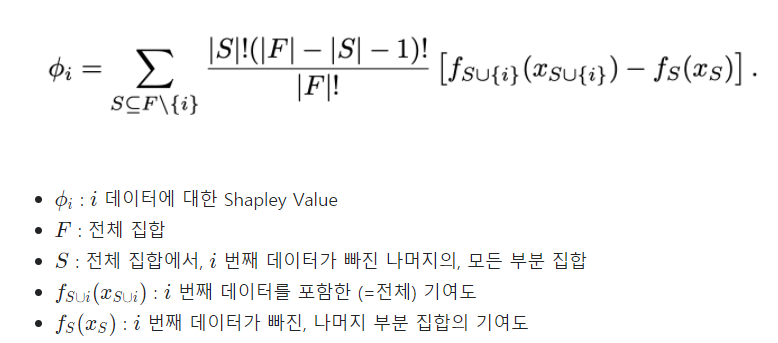  

- SHAP의  Explainer의  종류는  TreeExplainer,  DeepExplainer,  GradientExplainer,  LinearExplainer, KernelExplainer  5가지
    * KernelExplainer는  Model-agnostic으로  모든  모델에  적용  가능하지만  다른  유형의  알고리즘보다 느리다
    * TreeExplainer는 정확하고 속도가 빠름

- 변수가 4개면 모든 가능한 조합 2^(4-1) = 8개의 값을 산출하고 이를 가중평균하여 구함

In [12]:
model = RandomForestClassifier()
skf = StratifiedKFold(n_splits=2)
for train_index, test_index  in skf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
model.fit(X_train, y_train)
val_pred = model.predict(X_test)
score = f1_score(y_test, val_pred, average='weighted')

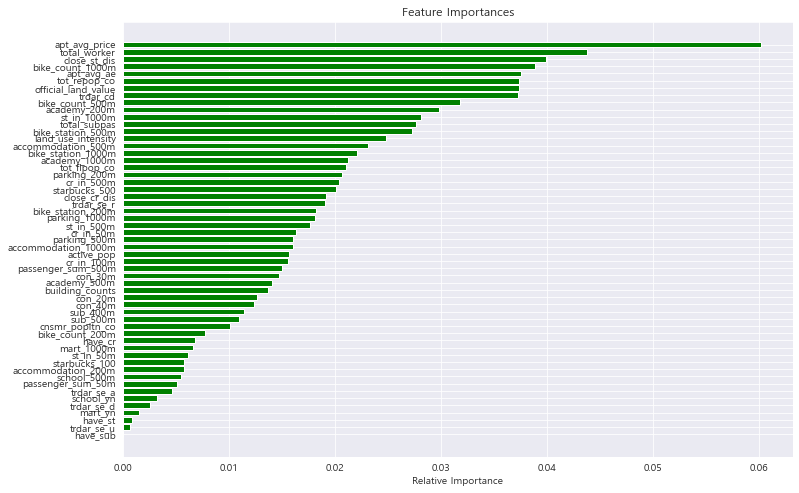

In [146]:
importances = model.feature_importances_
indices = np.argsort(importances)
features = X.columns
plt.figure(figsize=(12,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

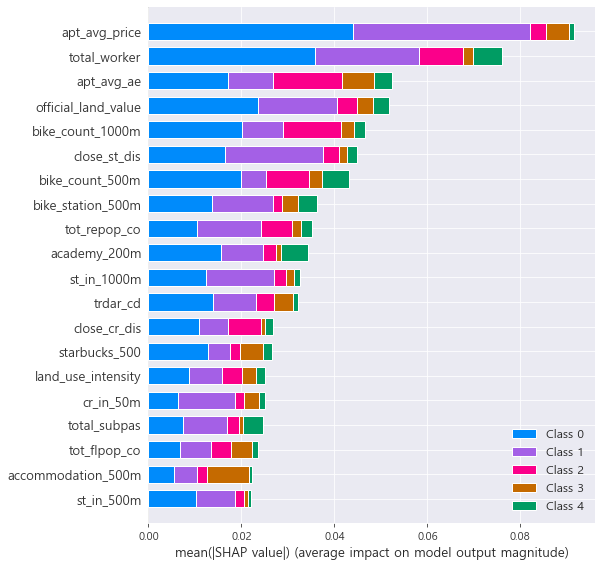

In [127]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

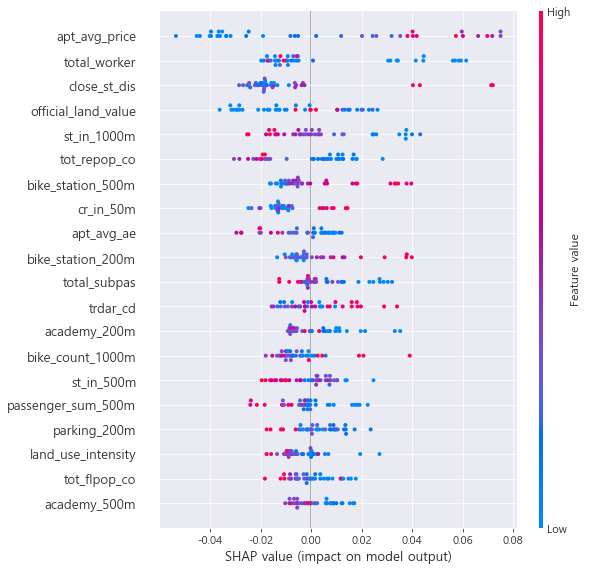

In [141]:
shap.summary_plot(shap_values[1], X_test.values, feature_names = X_test.columns)

> y축은 각 특성, x축은 shapely value를 나타냄, 빨간색일수록 높은값을 의미, apt_avg_price가 결과괎에 가장 큰 영향을 끼침 

apt_avg_price 특성값이 작을수록(파란색) 예측에 부정적인 영향을, 클수록(빨간색) 긍정적인 영향을 미친다

> 명확한  해석이  가능한  그래프는  feature  value에  다른  SHAP  value는  넓은  영역에  분산되어  있지  않고  특정  구간에  군집되어  있어야  한다.  feature  value가  낮을  때  SHAP  value가  높다면  반대로 feature value가 높을 때 SHAP value는 낮게 나타나야 명확한 해석이 가능하다. 

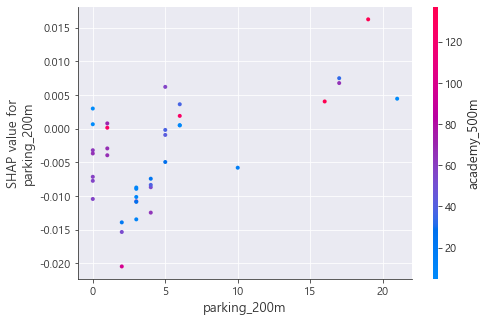

In [149]:
shap.dependence_plot(0, shap_values[0], X_test.values, feature_names=X_test.columns)

In [151]:
i=8
shap.force_plot(explainer.expected_value[0], shap_values[0][i], X_test.values[i], feature_names = X_test.columns)

> force_plot을 통해 트정 데이터 하나 또는 전체 데이터에 대해 Shapley value를 1차원 평면에 정렬해서 봄, 긍정적인 영향을 끼친 것은 빨간색, 부정적인 영향을 끼친 것은 파란색, base value와 가까울수록 큰영향(official_land_value, close_st_dis)

모델 predict_porba값: 0.59 

기본값 : 현재 인스턴스에 대한 기능을 알지 못하는 경우 예측할 값입니다. 기본 값은 훈련 데이터 세트(expected_value)에 대한 모델 출력의 평균, 이 예에서는 기본값 0.59

빨간색 모델 점수를 높인 기능 / 파란색은 점수를 낮춘 기능 

화살표가 클수록 출력에 대한 영향이 커짐 



Glyph 8722 missing from current font.
Glyph 8722 missing from current font.


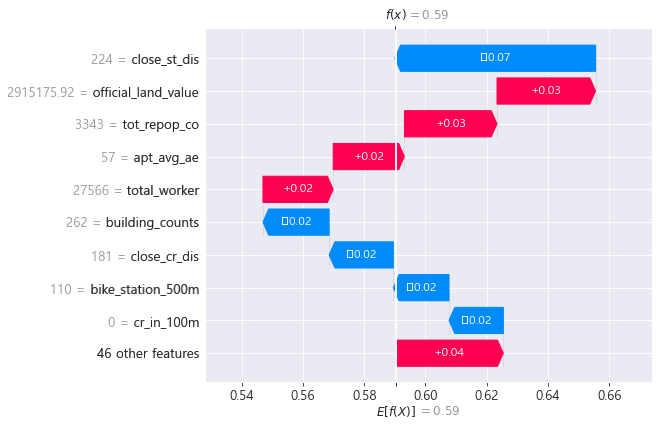

In [153]:
row = 8
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                              base_values=explainer.expected_value[0], data=X_test.iloc[row],  
                                         feature_names=X_test.columns.tolist()))

f(x)는 모델 predict_proba 값 : 0.59

기대값도 0.59

왼쪽에는 특성값과 화살표에는 예측에 대한 특성 기여도 

각 행은 각 기능의 양수(빨간색) 또는 음수(파란색) 기여도가 배경 데이터 세트의 예상 모델 출력에서 이 예측에 대한 모델 출력으로 값을 이동하는 방법을 보여줌

## III. Feature Selection

### 1) rfe
- 전체 기능 세트로 시작한 다음 예측 알고리즘을 사용하여 다음 단계를 반복
    * 모델을 피팅하고 기능 중요도 계산, 구현에 따라 교차 검증(CV) 사용이 포함될 수 있음
    * n 데이터 세트에서의 중요도가 가장 낮은 기능을 제거 
- RFE,RFECV -> 각 반복에서 제거할 변수를 선택하는 데 사용되는 기능 중요도 메트릭에 크게 의존(기능 중요도 메트릭은 선형 모델에 대한 계쑤(베타) 및 트리 기반 모델에 대한 불순물 기반 기능 중요도)
- 불순물 기반 중요도 : 모델의 모든 트리에서 주어진 기능에 의해 가져온 분할 기준의 정규화된 총 감소로 계산(기본적으로 트리 내에서 주어진 기능이 얼마나 높고 얼마나 자주 사용되는지 나타냄) -> 특성의 중요성으로 직접 해석되지 않을 뿐 아니라 방법이 높은 카디널리티 특성에 강하게 편향(더 고유한 값을 갖는 변수가 높은 중요도를 가질 가능성이 더 높음) 
- 각 반복에서 기능 수는 감소하지만 샘플 수는 각 반복에서 동일하게 유지되어 초기 반복에서는 모델이 과적합, 최종 반복에서는 모델이 과소적합될 가능성 존재 -> 모델이 데이터에 맞는지 호가인하려면 특성 중요도를 계산하기 전에 각 반복에서 하이퍼 파라미터를 최적화해야함

### 2) ShapRFECV
- 1. (선택 사항) GridSearchCV 또는 RandomizedSearchCV를 사용하여 모델의 하이퍼파라미터를 조정
- 2. CV(교차 검증)를 적용하여 제공된 데이터 세트에 대한 SHAP 기능 중요도를 추정합니다. 각 CV 폴드에서 튜닝된 모델은 기차 분할에 맞춰진 다음 검증 분할에서 평가되어 SHAP 기능 중요도를 추정
- 3. n데이터 세트에서 가장 낮은 SHAP 중요도 기능을 제거 n합니다. 여기서는 매개변수입니다.

> ShapRFECV의 경우 multiclass objective and metrics의 문제가 생김

In [218]:
from probatus.feature_elimination import ShapRFECV

In [224]:
model = RandomForestClassifier()
skf = StratifiedKFold(n_splits=2)
for train_index, test_index  in skf.split(dat1,target):
    X_train, X_test = dat1.iloc[train_index],dat1.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

from sklearn.model_selection import RandomizedSearchCV

random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 6, 8, 12],
               'min_samples_split': [5, 7, 10, 14],
               'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}

clf = RandomForestClassifier()
model_rf = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 80, 
                               cv = skf, scoring='f1_weighted',verbose= 5, random_state= 101, n_jobs = -1)
model_rf.fit(X_train,y_train)    
    
val_pred = model_rf.predict(X_test)
score = f1_score(y_test, val_pred, average='weighted')

Fitting 2 folds for each of 80 candidates, totalling 160 fits


In [253]:
param_grid = {
    'n_estimators': [5, 7, 10],
    'min_samples_leaf': [3, 5, 7, 10],
}

clf = RandomForestClassifier()
search  = RandomizedSearchCV(estimator = clf, param_distributions = random_search, random_state= 101)

In [ ]:
# step:각 반복에서 제거할 기능의 수 또는 백분율을 정의, 제거가 수행되는 속도를 수정 
shap_elimination = ShapRFECV(search , step=1, cv=5, scoring='f1_weighted',n_jobs=3)
report = shap_elimination.fit_compute(X_train,y_train)

In [ ]:
performance_plot = shap_elimination.plot()

다양한 수의 기능에 대한 모델의 학습 및 검증 분할에 대한 모델 성능(f1_weighted) 선은 cv평균 점수를 나타내고 음영 영역은 cv점수의 표준 편차를 나타남, (num_features :전체 피처의 개수 - 떨어지기 시작한 시점)

In [ ]:
shap_elimination.get_reduced_features_set(num_features=8)


In [241]:
from sklearn.feature_selection import RFECV
clf = RandomForestClassifier()
rfe = RFECV(clf, step=1, cv=10,n_jobs=3).fit(X_train, y_train)

In [251]:
rfe.support_

array([False,  True,  True,  True, False, False, False, False, False,
       False,  True,  True, False,  True,  True, False, False,  True,
        True,  True,  True, False,  True,  True, False, False, False,
       False, False, False,  True,  True,  True, False,  True, False,
        True,  True, False, False,  True,  True, False, False, False,
        True, False, False, False, False, False, False,  True,  True,
        True])

In [252]:
dat1.columns[rfe.support_].to_list()

['parking_500m',
 'parking_1000m',
 'academy_200m',
 'bike_count_500m',
 'bike_count_1000m',
 'bike_station_500m',
 'bike_station_1000m',
 'trdar_cd',
 'apt_avg_ae',
 'apt_avg_price',
 'tot_flpop_co',
 'tot_repop_co',
 'total_subpas',
 'total_worker',
 'active_pop',
 'close_cr_dis',
 'cr_in_50m',
 'cr_in_500m',
 'close_st_dis',
 'st_in_500m',
 'st_in_1000m',
 'trdar_se_r',
 'land_use_intensity',
 'official_land_value',
 'building_counts']

### 3) BorutaPy
- 중복 특성을 만들고 각 열의 값을 섞어 반응과의 상관 관계를 제거하여 특성에 임의성을 제거하는 것으로 시작(그림자 기능)
- 데이터 세트에서 임의로 분류기를 훈련시키고 Z_score를 수집하여 관련성/중요됴도 계산 

- BorutaPy 
    * estimator : regressor / classifier
    * n_estimators : 앙상블 기법의 의사결정 나무수, 'auto'시 데이터의 크기에 따라 자동으로 설정
    * perc : shadow features의 최대 feature importance를 100으로 했을 때 임계치 조정
    * alpha : Z-score 기반의 통계검정시 귀무가설 유의수준
    * max_iter : Iteration 반복 횟수
- BorutaPy.fit
    * n_features_ : 선택된 feature들의 개수를 리턴
    * support_ : 선택된 feature만 골라냄
    * support_weak_ : 버리기 애매한 feature 리턴
    * ranking_ : 선택된 피처는 1, 애매한 피처2, 나머지는 제거

In [199]:
from boruta import BorutaPy

In [204]:
feat_selector = BorutaPy(model, n_estimators= 'auto', verbose=2, random_state=0)
feat_selector.fit(dat1.values,target.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	55
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	55
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	55
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	55
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	55
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	55
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	55
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	44
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	44
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	44
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	44
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	45
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	45
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	45
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	45
Iteration: 	16 / 100
Confirmed: 	0
Tentative: 	10
Reject

BorutaPy(estimator=RandomForestClassifier(n_estimators=37,
                                          random_state=RandomState(MT19937) at 0x1D4C34B8A40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1D4C34B8A40, verbose=2)

In [205]:
feat_selector

BorutaPy(estimator=RandomForestClassifier(n_estimators=37,
                                          random_state=RandomState(MT19937) at 0x1D4C34B8A40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1D4C34B8A40, verbose=2)

In [212]:
dat1.columns[feat_selector.support_].to_list()

['bike_count_1000m', 'apt_avg_price', 'official_land_value']

In [213]:
dat1.columns[feat_selector.support_weak_].to_list()

['parking_1000m']

### 4) BorutaShap 

- BorutaShap :  Boruta feature selection algorithm +  SHAP (SHapley Additive exPlanations) technique
> t-test와 threshold를 통해서 중요하지 안는 변수를 통계적으로 분리

In [9]:
from BorutaShap import BorutaShap

In [12]:
Feature_Selector = BorutaShap(model=model,
                              importance_measure='shap',
                              classification=True)

In [14]:
Feature_Selector = BorutaShap(model=model,
                              importance_measure='shap',
                              classification=True)

Feature_Selector.fit(X=dat1, y=target, n_trials=100, sample=False,
                     train_or_test = 'test', normalize=True,
                     verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

6 attributes confirmed important: ['active_pop', 'parking_500m', 'parking_1000m', 'official_land_value', 'apt_avg_price', 'apt_avg_ae']
45 attributes confirmed unimportant: ['sub_500m', 'total_subpas', 'trdar_se_u', 'trdar_se_d', 'starbucks_100', 'tot_repop_co', 'st_in_50m', 'mart_1000m', 'have_sub', 'parking_200m', 'academy_500m', 'academy_200m', 'bike_count_200m', 'con_20m', 'cr_in_500m', 'land_use_intensity', 'bike_count_500m', 'sub_400m', 'cr_in_100m', 'tot_flpop_co', 'passenger_sum_500m', 'accommodation_500m', 'accommodation_1000m', 'building_counts', 'cr_in_50m', 'bike_count_1000m', 'cnsmr_popltn_co', 'academy_1000m', 'st_in_500m', 'passenger_sum_50m', 'school_yn', 'con_30m', 'con_40m', 'trdar_se_a', 'trdar_se_r', 'total_worker', 'have_cr', 'accommodation_200m', 'close_st_dis', 'close_cr_dis', 'mart_yn', 'have_st', 'school_500m', 'bike_station_200m', 'bike_station_1000m']
4 tentative attributes remains: ['starbucks_500', 'st_in_1000m', 'trdar_cd', 'bike_station_500m']


In [180]:
Feature_Selector.fit(X=dat1, y=target, n_trials=100, sample=False,
                    train_or_test = 'test', normalize=True,stratify=True,
                    verbose=True)


  0%|          | 0/100 [00:00<?, ?it/s]

6 attributes confirmed important: ['parking_500m', 'apt_avg_ae', 'official_land_value', 'active_pop', 'apt_avg_price', 'parking_1000m']
45 attributes confirmed unimportant: ['st_in_50m', 'academy_1000m', 'st_in_500m', 'passenger_sum_500m', 'passenger_sum_50m', 'cr_in_500m', 'academy_500m', 'cnsmr_popltn_co', 'sub_500m', 'con_40m', 'trdar_se_u', 'bike_station_200m', 'mart_yn', 'have_sub', 'bike_count_200m', 'building_counts', 'bike_count_1000m', 'have_cr', 'accommodation_500m', 'total_subpas', 'tot_repop_co', 'cr_in_50m', 'cr_in_100m', 'starbucks_100', 'mart_1000m', 'close_st_dis', 'trdar_se_a', 'total_worker', 'academy_200m', 'bike_station_1000m', 'tot_flpop_co', 'trdar_se_d', 'school_500m', 'con_30m', 'accommodation_1000m', 'con_20m', 'bike_count_500m', 'have_st', 'accommodation_200m', 'trdar_se_r', 'land_use_intensity', 'parking_200m', 'sub_400m', 'school_yn', 'close_cr_dis']
4 tentative attributes remains: ['starbucks_500', 'st_in_1000m', 'trdar_cd', 'bike_station_500m']


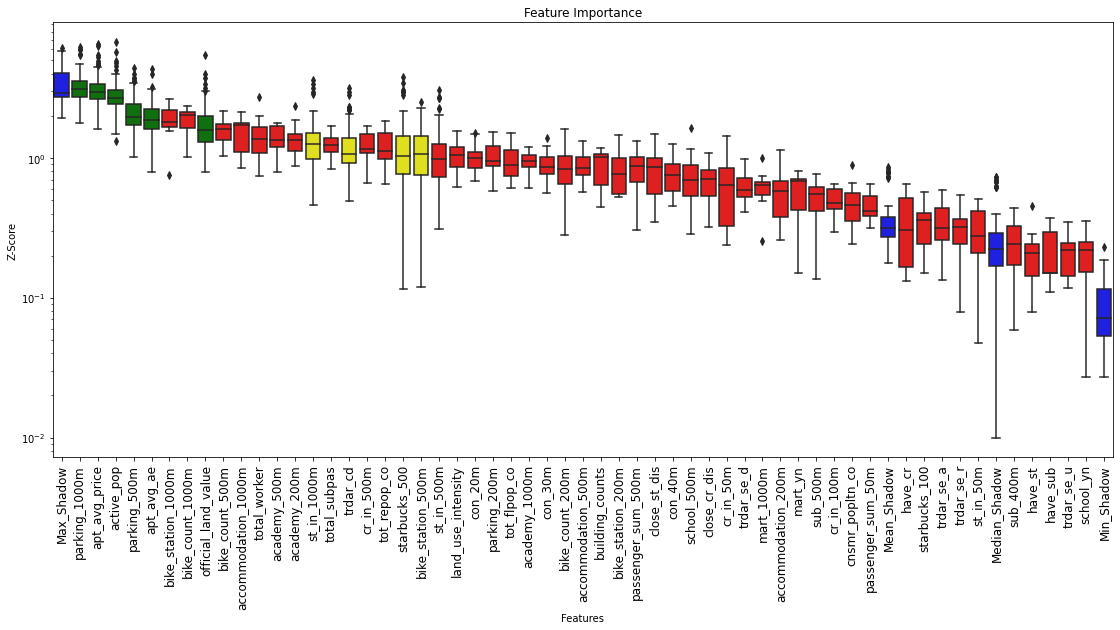

In [15]:
Feature_Selector.plot(X_size=12, figsize=(19,8),
                      y_scale='log', which_features='all',)

> 초록색 = accepted, 빨간색 = rejected

In [16]:
subset = Feature_Selector.Subset()
subset

,active_pop,parking_500m,parking_1000m,official_land_value,apt_avg_price,apt_avg_ae
0,747,1,22,3846887.30,279363095.0,57.0
1,1788,3,34,6539598.82,251141446.0,53.0
2,35,88,334,38722545.14,541220399.0,75.0
3,1253,15,55,2769418.72,131040098.0,58.0
4,1563,15,44,5001474.55,173992934.0,48.0
...,...,...,...,...,...,...
71,327,4,27,3445943.98,371583333.0,67.0
72,1707,7,32,2397686.28,107592090.0,48.0
73,1651,12,161,9193742.36,269155073.0,53.0
74,359,113,346,25108080.61,281223209.0,53.0


## IV. Modeling

In [32]:
subset = Feature_Selector.Subset()
model = RandomForestClassifier()
skf = StratifiedKFold(n_splits=2)
for train_index, test_index  in skf.split(subset,y):
    X_train, X_test = subset.iloc[train_index], subset.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
model.fit(X_train, y_train)
val_pred = model.predict(X_test)
score = f1_score(y_test, val_pred, average='weighted')

In [33]:
score

0.5278672872657835

In [20]:
dat2 = dat1.copy()
dat2 = dat2[ ['parking_500m', 'apt_avg_ae', 'official_land_value', 'active_pop', 'apt_avg_price', 'parking_1000m','starbucks_500', 'st_in_1000m', 'trdar_cd', 'bike_station_500m']]

In [29]:
        model = RandomForestClassifier()
        skf = StratifiedKFold(n_splits=2)
        for train_index, test_index  in skf.split(dat2,y):
            X_train, X_test = dat2.iloc[train_index], dat2.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        val_pred = model.predict(X_test)
        score = f1_score(y_test, val_pred, average='weighted')

In [22]:
model = trees_classifier(dat2, target,'Random Forest')
RF = model.model_fit()

Random Forest score : 0.4567628749292586


In [31]:
cv_results_df = pd.DataFrame(RF.cv_results_)
print(cv_results_df)

column = cv_results_df.loc[:, ["params"]]
print(column)

best_row = cv_results_df[cv_results_df['rank_test_score'] == 1]
print(best_row)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.067750      0.005872         0.009443        0.000063   
1         0.190388      0.006674         0.019530        0.000441   
2         0.242678      0.005311         0.024695        0.000366   
3         0.297159      0.003436         0.031419        0.000225   
4         0.353771      0.007745         0.038114        0.002246   
..             ...           ...              ...             ...   
895       0.219090      0.005540         0.024410        0.000964   
896       0.269170      0.007908         0.027151        0.000338   
897       0.328849      0.024390         0.035302        0.000409   
898       0.392249      0.009115         0.041789        0.001346   
899       0.579949      0.048704         0.066669        0.010485   

    param_bootstrap param_criterion param_max_depth param_max_features  \
0             False            gini               5               auto   
1             False    

KeyError: 'rank_test_score'

In [27]:
best_score = RF.best_score_
print(best_score)

cv_results_df = pd.DataFrame(RF.cv_results_)
best_row = cv_results_df.loc[[RF.best_index_]]
print(best_row)

best_max_depth = RF.best_params_['max_depth']
print(best_max_depth)

0.4567628749292586
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.06775      0.005872         0.009443        0.000063   

  param_bootstrap param_criterion param_max_depth param_max_features  \
0           False            gini               5               auto   

  param_min_samples_leaf param_min_samples_split  ...  \
0                     20                       2  ...   

  split0_test_recall_score split1_test_recall_score  mean_test_recall_score  \
0                 0.631579                 0.578947                0.605263   

   std_test_recall_score  rank_test_recall_score  split0_test_accuracy_score  \
0               0.026316                       1                    0.631579   

   split1_test_accuracy_score  mean_test_accuracy_score  \
0                    0.578947                  0.605263   

   std_test_accuracy_score  rank_test_accuracy_score  
0                 0.026316                         1  

[1 rows x 37 columns]
5


In [28]:
cv_results_df.T

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
mean_fit_time,0.06775,0.190388,0.242678,0.297159,0.353771,0.546628,0.073475,0.17852,0.258475,0.323141,...,0.306844,0.344469,0.415442,0.536439,0.069346,0.21909,0.26917,0.328849,0.392249,0.579949
std_fit_time,0.005872,0.006674,0.005311,0.003436,0.007745,0.039013,0.005774,0.004241,0.027434,0.020281,...,0.002312,0.006178,0.009066,0.012534,0.002131,0.00554,0.007908,0.02439,0.009115,0.048704
mean_score_time,0.009443,0.01953,0.024695,0.031419,0.038114,0.062274,0.01036,0.021216,0.027397,0.034471,...,0.032489,0.035041,0.04265,0.055347,0.011822,0.02441,0.027151,0.035302,0.041789,0.066669
std_score_time,0.000063,0.000441,0.000366,0.000225,0.002246,0.000033,0.001334,0.000105,0.001735,0.003844,...,0.000087,0.000858,0.000755,0.000928,0.000814,0.000964,0.000338,0.000409,0.001346,0.010485
param_bootstrap,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
param_criterion,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,...,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini
param_max_depth,5,5,5,5,5,5,5,5,5,5,...,10,10,10,10,10,10,10,10,10,10
param_max_features,auto,auto,auto,auto,auto,auto,auto,auto,auto,auto,...,auto,auto,auto,auto,auto,auto,auto,auto,auto,auto
param_min_samples_leaf,20,20,20,20,20,20,20,20,20,20,...,40,40,40,40,40,40,40,40,40,40
param_min_samples_split,2,2,2,2,2,2,5,5,5,5,...,30,30,30,30,60,60,60,60,60,60


## reference
- https://christophm.github.io/interpretable-ml-book/shap.html
- http://dmqm.korea.ac.kr/activity/seminar/297
- https://medium.com/ing-blog/open-sourcing-shaprfecv-improved-feature-selection-powered-by-shap-994fe7861560
- https://velog.io/@tobigs_xai/2%EC%A3%BC%EC%B0%A8-SHAP-SHapley-Additive-exPlanation